Density ratio: 1238.217002944369


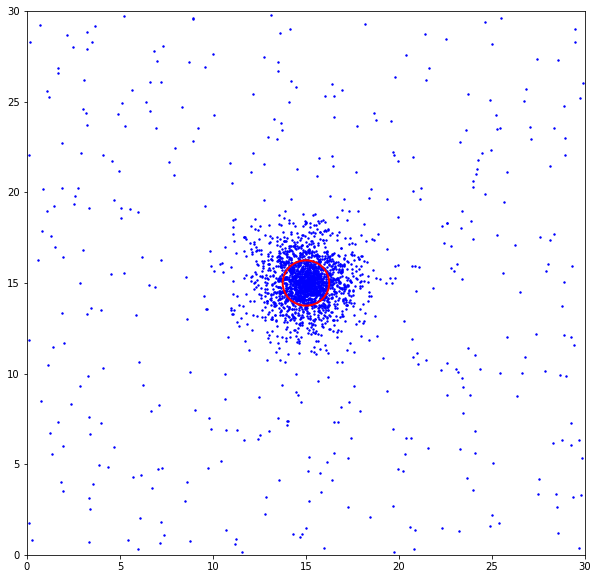

In [4]:
#simulate a galaxy with sersic profile

from cluster_gen import *
import numpy as np
from scipy import special

N_star_cluster=2000
n_bkg=0.46 #star/acrmin2
L=30 #arcmin
re=1.25 #arcmin
n=1.0
x_cent=L*0.5
y_cent=L*0.5

b=1.9992*n-0.3271
alfa=re/(b**n)
central_den=N_star_cluster/(2.0*np.pi*(alfa**2)*n*special.gamma(2.0*n))

print ("Density ratio: {}".format(central_den/n_bkg))

table_sim_cluster,table_sim_bkg=cluster_gen(N_star_cluster,n_bkg,L,re,n,x_cent,y_cent,bkg='uniform',plot_dist=False)

In [15]:
from mcmc_density import *
from astropy.table import Table

#mcmc fit of simulated object

x_all=np.append(table_sim_cluster['x'],table_sim_bkg['x'])
y_all=np.append(table_sim_cluster['y'],table_sim_bkg['y'])
r_all=np.append(table_sim_cluster['r'],table_sim_bkg['r'])

table_sim_all=Table([x_all,y_all,r_all],names=('x','y','r'))

x_i=table_sim_all['x']
y_i=table_sim_all['y']

Ntot=len(x_i)
A=L**2
sampler=''
profile='sersic'

if profile=='exponential':
    bkg_lim=Ntot/A

    x0=np.mean(x_i)
    y0=np.mean(y_i)
    ell0=0.1
    re0=0.1
    n_bkg0=0.1

    init_guess=[x0,y0,ell0,re0,n_bkg0]
    args=(x_i,y_i,Ntot,A,bkg_lim)
    ndim=len(init_guess)

    sampler=mcmc_density_fit(init_guess,args,'exp')
    
elif profile=='sersic':
    x0=np.mean(x_i)
    y0=np.mean(y_i)
    ell0=0.1
    re0=2.0
    n0=2.0

    init_guess=[x0,y0,ell0,re0,n]
    args=(x_i,y_i,A,Ntot,n_bkg)
    ndim=len(init_guess)

    sampler=mcmc_density_fit(init_guess,args,'sersic')

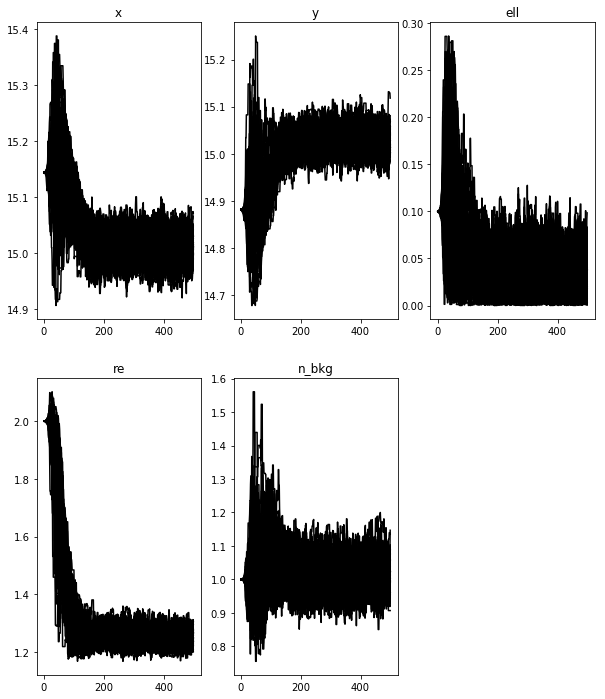

In [16]:
walkers_plot(figsize=(10,12),ncols=3,nrows=2,plot_number=5,sampler=sampler,titles=['x','y','ell','re','n'])

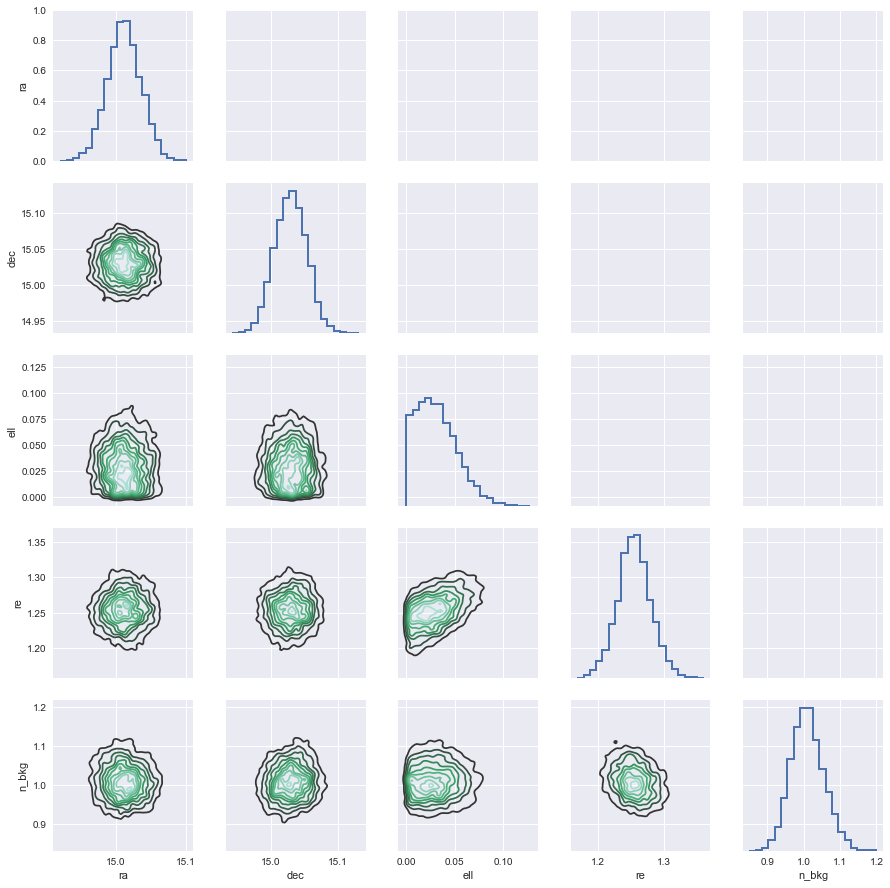

In [18]:
##plot pairgrid
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

samples=sampler.chain[:,250:,:].reshape((-1,ndim))
df=pd.DataFrame(samples,columns=["ra","dec","ell","re","n_bkg"])

plots=sns.PairGrid(df[["ra","dec","ell","re","n_bkg"]])
#plots.map_upper(pl.scatter)
plots.map_diag(plt.hist,histtype='step',lw=2,bins=20)
plots.map_lower(sns.kdeplot)

In [19]:
## Star selection
table_sim_cluster_pd=table_sim_cluster.to_pandas()
nstars=np.arange(5,2010,step=15)
for n in nstars:
    ind=[]
    stars_id=np.random.choice(table_sim_cluster_pd['ID'],size=n,replace=False)
    t=table_sim_cluster_pd[['ID','x','y','r']][table_sim_cluster_pd['ID'].isin(stars_id)]
    t=Table.from_pandas(t)
    t.write("shot_noise_samples/simulated_{}stars_{}arcmin_test.txt".format(int(n),L),format='ascii.commented_header',overwrite=True)

In [22]:
from astropy.io import ascii

cl_stars=np.array([])
sampler_all={}

profile='sersic'
for j in np.arange(5,2010,step=15):
    print ("Processing file simulated_{}stars.txt".format(j))
    sim_data=ascii.read("shot_noise_samples/simulated_{}stars_{}arcmin_test.txt".format(j,L),format='commented_header')
    
    ##add background stars
    x_i=np.append(sim_data['x'].data,table_sim_bkg['x'].data)
    y_i=np.append(sim_data['y'].data,table_sim_bkg['y'].data)
    A=L**2
    Ntot=len(x_i)
    sampler=''

    #assuming exponential profile
    if profile=='exponential':
        bkg_lim=Ntot/A

        x0=np.mean(x_i)
        y0=np.mean(y_i)
        ell0=0.9
        re0=2.0
        n_bkg=0.1 #variable value

        init_guess=[x0,y0,ell0,re0,n_bkg0]
        args=(x_i,y_i,Ntot,A,bkg_lim)
        ndim=len(init_guess)

        sampler=mcmc_density_fit(init_guess,args,'exp')
        
    elif profile=='sersic':
        
        x0=np.mean(x_i)
        y0=np.mean(y_i)
        ell0=0.5
        re0=3.0
        n=2.0
        
        n_bkg=0.46 #this is a fixed value

        init_guess=[x0,y0,ell0,re0,n]
        args=(x_i,y_i,A,Ntot,n_bkg)
        ndim=len(init_guess)

        sampler=mcmc_density_fit(init_guess,args,'sersic')
    
    samples=sampler.chain[:, 250:, :].reshape((-1, ndim))
    
    ell_test=np.mean(samples[:,2])
    ell_err_inf=ell_test-np.percentile(samples[:,2],16)
    ell_err_sup=np.percentile(samples[:,2],84)-ell_test
    
    re_test=np.mean(samples[:,3])
    re_err_inf=re_test-np.percentile(samples[:,3],16)
    re_err_sup=np.percentile(samples[:,3],84)-re_test
    
    n_test=np.mean(samples[:,4])
    n_err_inf=n_test-np.percentile(samples[:,4],16)
    n_err_sup=np.percentile(samples[:,4],84)-n_test
    
    print ("Number of object stars: {}".format(j))
    print ("Ellipticity: {} +/- {},{}".format(ell_test,ell_err_sup,ell_err_inf))
    print ("Effective radius: {} +/- {},{}".format(re_test,re_err_sup,re_err_inf))
    print ("Sersic index: {} +/- {},{}".format(n_test,n_err_sup,n_err_inf))
    print ("")
    
    cl_stars=np.append(cl_stars,j)
    
    sampler_all[str(j)]=sampler

Processing file simulated_5stars.txt
Number of object stars: 5
Ellipticity: 0.5249226230239493 +/- 0.3304103576953047,0.3325123513236765
Effective radius: 9.300314973671947 +/- 10.35506089391115,7.944992723661516
Sersic index: 7.354837708077149 +/- 6.885770653464823,5.569790886598241

Processing file simulated_20stars.txt
Number of object stars: 20
Ellipticity: 0.38014101141474166 +/- 0.23859083912977785,0.24119518763826467
Effective radius: 1.5791196152179536 +/- 0.6564922489481544,0.7020797261982912
Sersic index: 4.156836070863008 +/- 1.9031779004501743,2.027354419134384

Processing file simulated_35stars.txt
Number of object stars: 35
Ellipticity: 0.36639148634873453 +/- 0.15949985133237654,0.16803815812674744
Effective radius: 2.065176629002214 +/- 0.5128865433632219,0.4929682596721021
Sersic index: 1.1592918385990167 +/- 0.6142707788142674,0.5988537079379926

Processing file simulated_50stars.txt
Number of object stars: 50
Ellipticity: 0.4099075250050743 +/- 0.1378566662654872,0.1

In [23]:
#save data in table

results=[]

chains=np.array([x.chain[:,250:,:].reshape((-1,ndim)) for x in list(sampler_all.values())])

for i in range(5):
    mean=np.mean(chains[:,:,i],axis=1)
    results.append(mean)
    results.append(mean-np.percentile(chains[:,:,i],16,axis=1))
    results.append(np.percentile(chains[:,:,i],84,axis=1)-mean)

results=np.append(cl_stars,results)
results=np.array(results).reshape((16,-1))
t=Table(list(results),names=('member_stars','x0','x0_err_inf','x0_err_sup','y0','y0_err_inf','y0_err_sup',\
                     'ell','ell_err_inf','ell_err_sup','re','re_err_inf','re_err_sup',\
                      'n','n_err_inf','n_err_sup'))
t.write("shot_noise_results/shot_noise_parameters_{}arcmin_test.txt".format(L),\
        format='ascii.commented_header',overwrite=True)

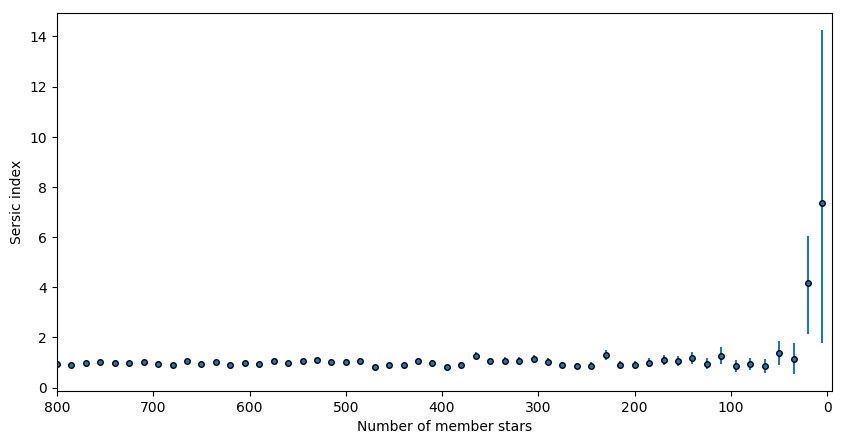

In [9]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import ascii

sns.reset_orig()

field = 'n'
labels = {'ell':'Ellipticty','re':"log Effective Radius [pc]",'n':'Sersic index'}

plt.figure(figsize=(10,5))
for i in [L]:
    #read table
    t=ascii.read("shot_noise_results/shot_noise_parameters_{}arcmin_test.txt".format(i),\
                 format='commented_header')
    yerr=np.append(t["{}_err_inf".format(field)],t["{}_err_sup".format(field)]).reshape(2,len(t["{}_err_inf".format(field)]))
    plt.errorbar(t["member_stars"],t[field],yerr=yerr,ls='None',marker='o',ms='4',\
                label="{}x{} fov".format(i,i))

plt.xlabel("Number of member stars")
plt.ylabel(labels[field])
#pl.xlim(0,1500)
plt.gca().invert_xaxis()
plt.style.use('classic')
#pl.text(2000,0.5,"Nstars = {}\nRe = {}'\nn_bkg={}'-2\nn = {}"\
#        .format(N_star_cluster,re,n_bkg,n))
#pl.legend(fontsize='small')

#density ratio line
nn=np.linspace(5,2000,10000)
cnn=nn/(2.0*np.pi*(alfa**2)*n*special.gamma(2.0*n))
r=cnn/n_bkg
ind,=np.where(r>=5.0)
ind=ind[0]
#pl.axvline(nn[ind],color='r')
plt.xlim(800,-5)
plt.savefig('shot_noise_plots/shot_noise_simulated_{}arcmin_{}.pdf'.format(L,field))
plt.show()